In [1]:
using Plots
using Random
using LaTeXStrings
using Optim

rng = Xoshiro(14588); # set random number generator seed

In this notebook we are going to 

* solve a linear parameter identification problem with 
    * ordinary least squares (OLS) and 
    * prediction error method (PEM) to
* compare their prediction / simulation performance for different prediction lengths.

We again consider our toy example $$x[k+1] = \underbrace{\left(1+\frac{\Delta t}{\tau}\right)}_{a}x[k] + \underbrace{\left(V_{\mathrm{s}}\frac{\Delta t}{\tau}\right)}_{b}u[k] $$
for illustration purpose. 

In [2]:
Δt = 1; # time step width in s
Vs = 1; # Steady-state gain
τ = 15; # Time constant in s

a = (1-Δt/τ);
b = (Vs*Δt/τ);

# Generate input signal as multiple step functions towards +1 and -1 without a loop
N = 1000; # number of samples
u = zeros(N);
u[1:250] .= 1;
u[251:500] .= -1;
u[501:750] .= 1;
u[751:1000] .= -1;

# Generate output signal
x = zeros(N);
x[1] = 0;
for k = 2:N
    x[k] = a*x[k-1] + b*u[k-1];
end

# Add measurement noise to the states
σ = 0.1; # standard deviation of measurement noise
y = x + σ*randn(N); # add noise to the states and define measurement ouput y


First, we find the usual OLS solution.

In [24]:
#set up an OLS problem to identify the parameters of the model
Y_OLS = y[2:end];
Z_OLS = [y[1:end-1] u[1:end-1]];
w_OLS = inv(Z_OLS'*Z_OLS)*Z_OLS'*Y_OLS;

Next, we find the PEM solution.

In [26]:
# Cost function with input arguments w (parameter -> opt. variable), u (input trajectory),  y (measurement data)
function costs(w, u, y)
    N = length(u)
    x = zeros(eltype(w), N); # initialize state vector
    for k = 2:N # simulate the system
        x[k] = w[1]*x[k-1] + w[2]*u[k-1];
    end
    return sum(abs2.(y .- x)) # return the sum of squared errors
end;

res = optimize(w -> costs(w, u, y), [0.0, 0.0], Newton(); autodiff=:forward)
w_PEM = Optim.minimizer(res); # extract the optimal parameter values

To compare the identification results, we define a new cost function which evaluates the model accuracy on a receding horizon, that is, we initialize the model using the most recent measurement of $x[k]$ and perform a $N_\mathrm{p}$ step prediction and evaluate the cost from $i=k+1 \ldots k+N_\mathrm{p}$ repetitively over the available data points $k=1 \ldots N$.

In [27]:
function predict_error_costs(w, u, y, Np)
    N = length(u)
    costs = 0   
    for k = 1:Np:N-1
        if k+Np > N
            break
        end
        x = ones(Np+1)
        x[1] = y[k]
        for ii = 1:Np
            x[ii+1] = w[1]*x[ii] + w[2]*u[k+ii-1];
        end
        costs += sum(abs2.(y[k+1:k+Np] - x[2:Np+1]));
    end
    return costs
end;

Calculate the sum of squared residuals for both parameter identification techniques consider different values for $N_\mathrm{p}$.

In [7]:
Np_vec = 1:100
costs_PEM = zeros(length(Np_vec))
costs_OLS = zeros(length(Np_vec))
for ii in Np_vec 
    costs_PEM[ii] = predict_error_costs(w_PEM, u, y, ii)
    costs_OLS[ii] = predict_error_costs(w_OLS, u, y, ii)
end


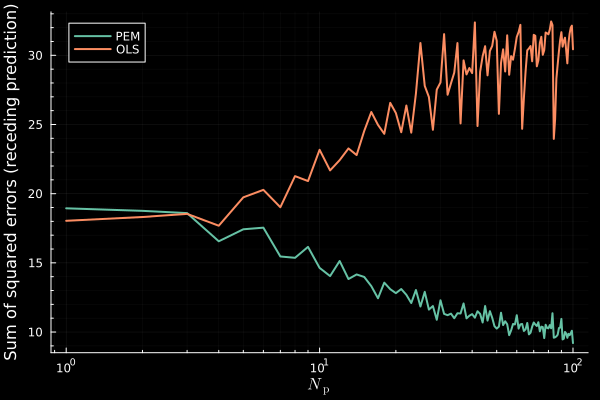

In [23]:
# Plot costs over number of Np prediction steps using a logarithmic x axis scale
plot(Np_vec, costs_PEM, label="PEM", xlabel=L"N_\mathrm{p}", ylabel="Sum of squared errors (receding prediction)", 
xscale=:log10, lw=2, legend=:topleft, minorgrid=true, 
background_color="#000000", palette = :Set2_5)

plot!(Np_vec, costs_OLS, label="OLS", lw=2)

